# Introduction to the Reverse Osmosis Unit Model
This tutorial shows how to build, initialize, simulate, and optimize a reverse osmosis (RO) unit model using WaterTAP. In this example, we will minimize the specific energy consumption of the RO unit.

<p align="center">
<img src='img/wf_8steps.svg' alt="Basic Worflow" width="500">
</p>

## Step 1: Import libraries from Pyomo, IDAES and WaterTAP.

<p align="center">
<img src='img/wf_8steps_1.svg' alt="Basic Worflow" width="500">
</p>

In [297]:
# Imports from Pyomo
from pyomo.environ import (
    ConcreteModel,
    Objective,
    Expression,
    value,
    check_optimal_termination,
    units as pyunits,
)  # including "value" for getting the value of Pyomo objects

# Imports from IDAES
from idaes.core import FlowsheetBlock  # Import flowsheet block from IDAES core
from watertap.core.solvers import get_solver  # Import function to get default solver
from idaes.core.util.model_statistics import (
    degrees_of_freedom,
)  # Import function to check degrees of freedom
from idaes.core.util.scaling import (
    calculate_scaling_factors,
    set_scaling_factor,
)  # Import utility function for calculating scaling factors


# Imports from WaterTAP
from watertap.property_models.NaCl_prop_pack import (
    NaClParameterBlock,
)  # Import NaCl property model
from watertap.unit_models.reverse_osmosis_0D import ReverseOsmosis0D  # Import RO model
from watertap.core import ConcentrationPolarizationType, MassTransferCoefficient

## Step 2: Build the RO model.

<p align="center">
<img src='img/wf_8steps_2.svg' alt="Basic Worflow" width="500">
</p>

Create a Pyomo concrete model, flowsheet, and NaCl property parameter block. Add an RO unit to the flowsheet.



In [264]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = NaClParameterBlock()

m.fs.unit = ReverseOsmosis0D(
    property_package=m.fs.properties,
    concentration_polarization_type=ConcentrationPolarizationType.none,
    mass_transfer_coefficient=MassTransferCoefficient.none,
    has_pressure_change=False,
)

## Step 3: Specify values for system variables.

<p align="center">
<img src='img/wf_8steps_3.svg' alt="Basic Worflow" width="500">
</p>

In [265]:
m.fs.unit.inlet.flow_mass_phase_comp[0, "Liq", "NaCl"].fix(
    0.035
)  # mass flow rate of NaCl (kg/s)
m.fs.unit.inlet.flow_mass_phase_comp[0, "Liq", "H2O"].fix(
    0.965
)  # mass flow rate of water (kg/s)
m.fs.unit.inlet.pressure[0].fix(50e5)  # feed pressure (Pa)
m.fs.unit.inlet.temperature[0].fix(298.15)  # feed temperature (K)
m.fs.unit.area.fix(50)  # membrane area (m^2)
m.fs.unit.A_comp.fix(4.2e-12)  # membrane water permeability (m/Pa/s)
m.fs.unit.B_comp.fix(3.5e-8)  # membrane salt permeability (m/s)
m.fs.unit.permeate.pressure[0].fix(101325)  # permeate pressure (Pa)

## Step 4: Scale all variables.

<p align="center">
<img src='img/wf_8steps_4.svg' alt="Basic Worflow" width="500">
</p>

Set scaling factors for component mass flowrates, membrane area and all other variables.


In [266]:
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1, index=("Liq", "H2O"))
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1e2, index=("Liq", "NaCl"))
set_scaling_factor(m.fs.unit.area, 1e-2)
calculate_scaling_factors(m)

## Step 5: Initialize the model.

<p align="center">
<img src='img/wf_8steps_5.svg' alt="Basic Worflow" width="500">
</p>

In [267]:
m.fs.unit.initialize()

2026-01-16 05:25:05 [INFO] idaes.init.fs.unit.feed_side: Initialization Complete
2026-01-16 05:25:06 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found


## Step 6: Setup a solver and run multiple simulations.
Check that degrees of freedom = 0 before attempting simulation. This means that the performance of the flowsheet is completely determined by the system variables that were fixed above. Then run the simulation and report the results.

<p align="center">
<img src='img/wf_8steps_6.svg' alt="Basic Worflow" width="500">
</p>

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Assume 100% efficiency of pumps and ERD and no pressure losses
# --> Pump power consumption ~ Qp*Pf/3.6e6
m.fs.specific_energy_consumption = Expression(
    expr=m.fs.unit.inlet.pressure[0] / (3.6e6)
)

list_dict = []

area_bounds = [1, 500]
pressure_bounds = [10e5, 80e5]
pressure_gridnum = 57
area_gridnum = 20



specific_energy_consumption (type=<class
'pyomo.core.base.expression.ScalarExpression'>) on block fs with a new
Component (type=<class 'pyomo.core.base.expression.ScalarExpression'>). This
is usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


In [325]:
pressure_gridnum

57

In [324]:
aa = np.linspace(area_bounds[0], area_bounds[1], area_gridnum)
pp = np.linspace(pressure_bounds[0], pressure_bounds[1], pressure_gridnum)
pp

array([1000000., 1125000., 1250000., 1375000., 1500000., 1625000.,
       1750000., 1875000., 2000000., 2125000., 2250000., 2375000.,
       2500000., 2625000., 2750000., 2875000., 3000000., 3125000.,
       3250000., 3375000., 3500000., 3625000., 3750000., 3875000.,
       4000000., 4125000., 4250000., 4375000., 4500000., 4625000.,
       4750000., 4875000., 5000000., 5125000., 5250000., 5375000.,
       5500000., 5625000., 5750000., 5875000., 6000000., 6125000.,
       6250000., 6375000., 6500000., 6625000., 6750000., 6875000.,
       7000000., 7125000., 7250000., 7375000., 7500000., 7625000.,
       7750000., 7875000., 8000000.])

In [ ]:

for a in aa:
    for p in pp:
        m.fs.unit.area.fix(a)  # membrane area (m^2)
        m.fs.unit.inlet.pressure[0].fix(p)  # feed pressure (Pa)
        assert degrees_of_freedom(m) == 0  # Check DOF
        solver = get_solver()  # Setup solver
        simulation_results = solver.solve(m)  # Run simulation

        if check_optimal_termination(simulation_results):
            recovery = m.fs.unit.recovery_vol_phase[0, "Liq"].value
            sec =m.fs.specific_energy_consumption()
            d = {'area': a, 'inlet pressure': p, 'recovery': recovery, 'SEC': sec, 'feasible': True}
            pass
        else:
            d = {'area': a,'inlet pressure': p, 'recovery': np.nan, 'SEC': np.nan, 'feasible': False}
            pass
        list_dict.append(d)
        pass
    pass

df = pd.DataFrame(data=list_dict)

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.

<Axes: xlabel='inlet pressure', ylabel='recovery'>

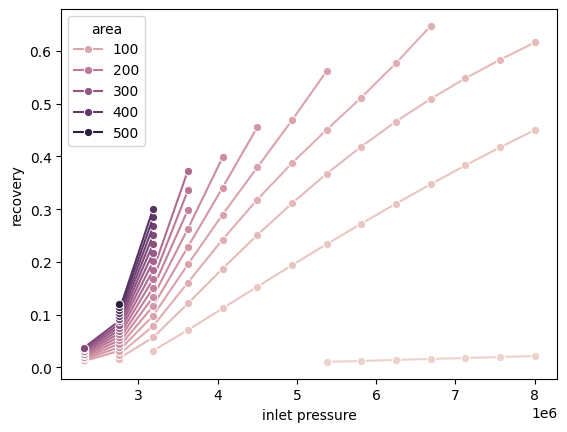

In [270]:
import seaborn as sns


[fig, ax] = plt.subplots(1,1, sharex='col')
sns.lineplot(data=df, x="inlet pressure", y="recovery", hue="area", ax =ax ,marker='o')


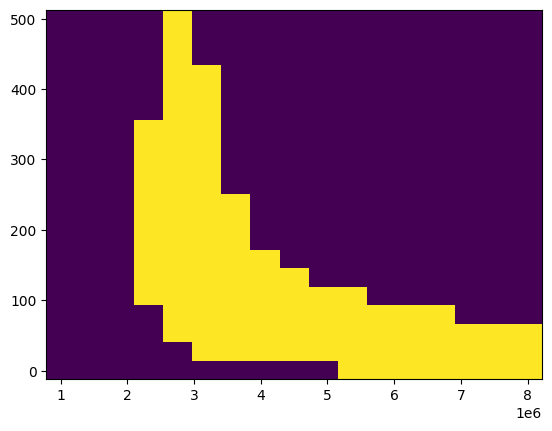

In [284]:
[fig, ax] = plt.subplots(1,1)
Z = df['feasible'].values.reshape([area_gridnum,pressure_gridnum, ])
ax.pcolormesh(pp,aa,Z)


In [272]:
assert degrees_of_freedom(m) == 0  # Check DOF
solver = get_solver()  # Setup solver
simulation_results = solver.solve(m)  # Run simulation
m.fs.unit.report()  # Display report, reports include a small subset of the most important variables

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.

Unit : fs.unit                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value   : Units         : Fixed : Bounds
                 Membrane Area :  500.00 :    meter ** 2 :  True : (0.1, 100000.0)
    Solvent Mass Recovery Rate : 0.99906 : dimensionless : False : (0.01, 0.999999)
      Volumetric Recovery Rate : 0.99896 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                               Units         Feed Inlet  Feed Outlet  Permeate Outlet
    flow_mass_phase_comp ('Liq', 'H2O')   kilogram / second     0.96500  0.00090626 

In [273]:
# Display all results, this shows all variables and constraints
m.fs.unit.display()

Block fs.unit

  Variables:
    area : Total Membrane area
        Size=1, Index=None, Units=m**2
        Key  : Lower : Value : Upper    : Fixed : Stale : Domain
        None :   0.1 : 500.0 : 100000.0 :  True :  True : NonNegativeReals
    _flow_mass_phase_comp_inlet_ref : Size=2, Index=fs._time*fs.properties.phase_list*fs.properties.component_list, ReferenceTo=fs.unit.feed_side.properties_in[...].component('flow_mass_phase_comp')[...]
        Key                  : Lower : Value : Upper : Fixed : Stale : Domain
         (0.0, 'Liq', 'H2O') :   0.0 : 0.965 :  None :  True :  True : NonNegativeReals
        (0.0, 'Liq', 'NaCl') :   0.0 : 0.035 :  None :  True :  True : NonNegativeReals
    _temperature_inlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.unit.feed_side.properties_in[...].component('temperature')
        Key : Lower  : Value  : Upper  : Fixed : Stale : Domain
        0.0 : 273.15 : 298.15 : 373.15 :  True :  True : NonNegativeReals
    _pressure_inlet_ref : Size=1, Index

## Step 7: Optimize RO unit

<p align="center">
<img src='img/wf_8steps_7.svg' alt="Basic Worflow" width="500">
</p>

### Step 7.1: Unfix variables (membrane area, feed pressure) and set variable bounds

<p align="center">
<img src='img/wf_8steps_7-1.svg' alt="Basic Worflow" width="500">
</p>

In [274]:
m.fs.unit.area.unfix()  # unfix membrane area (m^2)
m.fs.unit.inlet.pressure[0].unfix()  # unfix feed pressure (Pa)

# Set lower and upper bounds for membrane area (m^2)


m.fs.unit.area.setlb(area_bounds[0])
m.fs.unit.area.setub(area_bounds[1])

# Set lower and upper bounds for feed pressure (Pa)
m.fs.unit.inlet.pressure[0].setlb(pressure_bounds[0])
m.fs.unit.inlet.pressure[0].setub(pressure_bounds[1])

## Step 7.2: Add constraints and objective 

<p align="center">
<img src='img/wf_8steps_7-2.svg' alt="Basic Worflow" width="500">
</p>

Minimize the specific energy consumption (energy / permeate flow) with a 50% water recovery constraint.

In [275]:
# Assume 100% efficiency of pumps and ERD and no pressure losses
# --> Pump power consumption ~ Qp*Pf/3.6e6
'''
m.fs.specific_energy_consumption = Expression(
    expr=m.fs.unit.inlet.pressure[0] / (3.6e6)
)
'''

# Define objective function to minimize the specific energy consumption.
m.fs.objective = Objective(expr=m.fs.specific_energy_consumption)

# Set the water recovery to 50%
m.fs.unit.recovery_vol_phase[0, "Liq"].fix(0.50)

### Step 7.3: Run optimization to minimize specific energy consumption

<p align="center">
<img src='img/wf_8steps_7-3.svg' alt="Basic Worflow" width="500">
</p>

The optimization problem will find the membrane area and inlet pressure that achieve 50% recovery while minimizing specific energy consumption. 

In [276]:
# Check DOF
print(degrees_of_freedom(m))

# Solve the model
optimization_results = solver.solve(m)

1


## Step 8: Analyze Results

<p align="center">
<img src='img/wf_8steps_8.svg' alt="Basic Worflow" width="500">
</p>

<div class="alert alert-block alert-info">
<b>Note:</b> You can analyze and visualize model status and results at any point during the process, not strictly at the end.
</div>

In [ ]:
print(optimization_results)

area_opt = value(m.fs.unit.area)
pressure_opt = value(m.fs.unit.inlet.pressure[0])

# Display results of the optimized system
print(f"Optimized membrane area: {area_opt} {}")
print(f"Optimized membrane pressure: {value(m.fs.unit.inlet.pressure[0])}")
print(f"Specific energy consumption: {value(m.fs.specific_energy_consumption)}")


Problem: 
- Lower bound: -.inf
  Upper bound: .inf
  Number of objectives: 1
  Number of constraints: 92
  Number of variables: 93
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.06937432289123535
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized membrane area: 143.93509276832316
Optimized membrane pressure: 4526950.046962015
Specific energy consumption: 1.2574861241561153


m**2


In [278]:
m.fs.unit.recovery_vol_phase[0, "Liq"].value

0.5

In [ ]:
print()

Pa


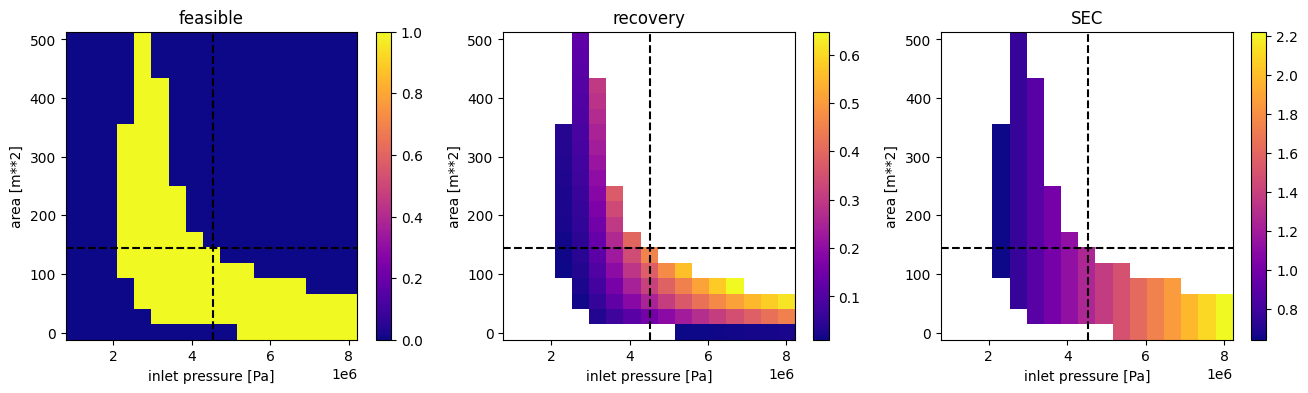

In [305]:
[fig, axs] = plt.subplots(1,3, figsize=(16,4))

for var_index, var_name in enumerate(['feasible', 'recovery', 'SEC']):
    ax = axs[var_index]
    Z = df[var_name].values.reshape([area_gridnum,pressure_gridnum, ])
    cf = ax.pcolormesh(pp,aa,Z, cmap='plasma')


    ax.axhline(area_opt, color='k', ls='--')
    ax.axvline(pressure_opt, color='k', ls='--')

    fig.colorbar(cf, ax=ax)
    ax.set_title(var_name)
    ax.set_xlabel(f'inlet pressure [{pyunits.get_units(m.fs.unit.inlet.pressure[0])}]')
    ax.set_ylabel(f'area [{pyunits.get_units(m.fs.unit.area)}]')
    pass

In [280]:
df_pivot.columns

Index([1.0, 100.8, 200.6, 300.4, 400.2, 500.0], dtype='float64', name='area')

In [281]:
ax2.get_ylim()

(np.float64(0.0), np.float64(1.0))

In [282]:

m.fs.unit.report()


Unit : fs.unit                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value   : Units         : Fixed : Bounds
                 Membrane Area :  143.94 :    meter ** 2 : False : (1, 500)
    Solvent Mass Recovery Rate : 0.50466 : dimensionless : False : (0.01, 0.999999)
      Volumetric Recovery Rate : 0.50000 : dimensionless :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                               Units         Feed Inlet  Feed Outlet  Permeate Outlet
    flow_mass_phase_comp ('Liq', 'H2O')   kilogram / second     0.96500     0.47801        0.48699   
    flow_mass_phase_comp ('Liq', 'NaCl')  kilogram / second    0.035000    0.034778     0.00022231   
    temperature                                      kelvin      29